In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
# ignore the warnings which occur when we apply a certain model on dataset
import warnings
warnings.simplefilter(action='ignore')

In [3]:
# import all the necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt   # matplotlib for plotting the charts
import seaborn as sns             # seaborn for visualization of the dataset and its columns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,f1_score

# **DATA LOADING**

In [4]:
# reading all the necessary files,the Movies Dataset, the Train Dataset, the Test Dataset 
# containing all the necessary Details

movies=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
train=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
sample=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')

**INFORMATION GATHERING for each dataset**

In [5]:
# checking for no. of rows and columns in movies dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [6]:
# checking for no. of rows and columns in train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [7]:
# checking for no. of rows and columns in train dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


**NULL VALUES SUM CHECK**

In [8]:
# checking for column wise sum of null values in movies dataset
movies.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [9]:
# checking for column wise sum of null values in train dataset
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [10]:
# checking for column wise sum of null values in test dataset
test.isnull().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [11]:
print('Shape of Movies Dataset: ',movies.shape) #shape of movies dataset (rows, columns)
print('Shape of Train Dataset: ',train.shape)   #shape of movies dataset (rows, columns)
print('Shape of Test Dataset: ',test.shape)     #shape of movies dataset (rows, columns)

Shape of Movies Dataset:  (143258, 14)
Shape of Train Dataset:  (162758, 5)
Shape of Test Dataset:  (55315, 4)


**DATA CLEANING - REMOVING DUPLICATES**

In [12]:
# drop the duplicate values of movies dataset before merging
# use subset 'movieId' to define a particular column to work upon
# keep first will keep the first value and remove the remaining duplicates

unique_movies = movies.drop_duplicates(subset='movieid', keep='first')

**MERGING THE DATASETS TO CREATE NEW ONES**

In [13]:
# merge the train and new movies dataset such that train data remains intact and no new rows are added
# left join
# common key for merging is 'movieId' in both datasets

movie_train = pd.merge(train, unique_movies, on='movieid', how='left')

In [14]:
# merge the test and new movies dataset such that test data remains intact and no new rows are added
# left join
# common key for merging is 'movieId' in both datasets

movie_test = pd.merge(test, unique_movies, on="movieid", how="left")

In [15]:
# describe new train dataset to check the standard deviation and mean etc values of the numerical columns
movie_train.describe()

,audienceScore,runtimeMinutes
count,149510.000000,159382.000000
mean,65.214541,106.911828
std,19.937695,22.138131
min,0.000000,4.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,82.000000,118.000000
max,100.000000,561.000000


In [16]:
# info to check the new structure of test dataset to be used for prediction
movie_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieid               55315 non-null  object 
 1   reviewerName          55315 non-null  object 
 2   isTopCritic           55315 non-null  bool   
 3   reviewText            52805 non-null  object 
 4   title                 55315 non-null  object 
 5   audienceScore         50384 non-null  float64
 6   rating                31019 non-null  object 
 7   ratingContents        31019 non-null  object 
 8   releaseDateTheaters   41613 non-null  object 
 9   releaseDateStreaming  49341 non-null  object 
 10  runtimeMinutes        54053 non-null  float64
 11  genre                 54395 non-null  object 
 12  originalLanguage      54077 non-null  object 
 13  director              55315 non-null  object 
 14  boxOffice             35320 non-null  object 
 15  distributor        

# DATA CLEANING

In [17]:
# THE COLUMNS WHICH ARE OF NO USE COULD BE DROPPED
drop_column = ['reviewerName','isFrequentReviewer','ratingContents','releaseDateTheaters','releaseDateStreaming','director','distributor','soundType','originalLanguage']

# drop the list of columns from train and test dataset
movie_train.drop(drop_column, axis=1, inplace=True)
drop_column = ['reviewerName','ratingContents','releaseDateTheaters','releaseDateStreaming','director','distributor','soundType','originalLanguage']
movie_test.drop(drop_column, axis=1, inplace=True)

In [18]:
movie_train.shape # define the shape for new datasets

(162758, 9)

In [19]:
movie_test.shape # define the shape for new datasets

(55315, 9)

In [20]:
movie_test.info() # checking for the new dataset structure

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieid         55315 non-null  object 
 1   isTopCritic     55315 non-null  bool   
 2   reviewText      52805 non-null  object 
 3   title           55315 non-null  object 
 4   audienceScore   50384 non-null  float64
 5   rating          31019 non-null  object 
 6   runtimeMinutes  54053 non-null  float64
 7   genre           54395 non-null  object 
 8   boxOffice       35320 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 3.9+ MB


**SPLITTING DATA INTO X AND Y**

In [21]:
# separate feature columns into x train
X_train = movie_train.drop(["sentiment"], axis = "columns")

# separate target column => 'sentiment' into y train
y_train = movie_train["sentiment"]

**SPLITTING INTO TRAINING AND VALIDATION DATA**

In [22]:
# split the training data further into training and validation
# size of validation data is 25% of the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 42)

In [23]:
# filling the empty values in the text feature before preprocessing
# replacing the NAN values with empty string

X_train['reviewText'] = X_train['reviewText'].fillna(" ")
X_val['reviewText'] = X_val['reviewText'].fillna(" ")
movie_test['reviewText'] = movie_test['reviewText'].fillna(" ")

In [24]:
X_train.isnull().sum()   # null values sum in training data

movieid               0
reviewText            0
title                 0
audienceScore      9982
rating            47830
runtimeMinutes     2515
genre              1837
boxOffice         39580
dtype: int64

In [25]:
X_val.isnull().sum()   # null values sum in validation data

movieid               0
reviewText            0
title                 0
audienceScore      3266
rating            15894
runtimeMinutes      861
genre               601
boxOffice         13196
dtype: int64

In [26]:
X_train.select_dtypes(include='number').columns    # to check the numerical features present in traning dataset

Index(['audienceScore', 'runtimeMinutes'], dtype='object')

# DATA VISUALIZATION

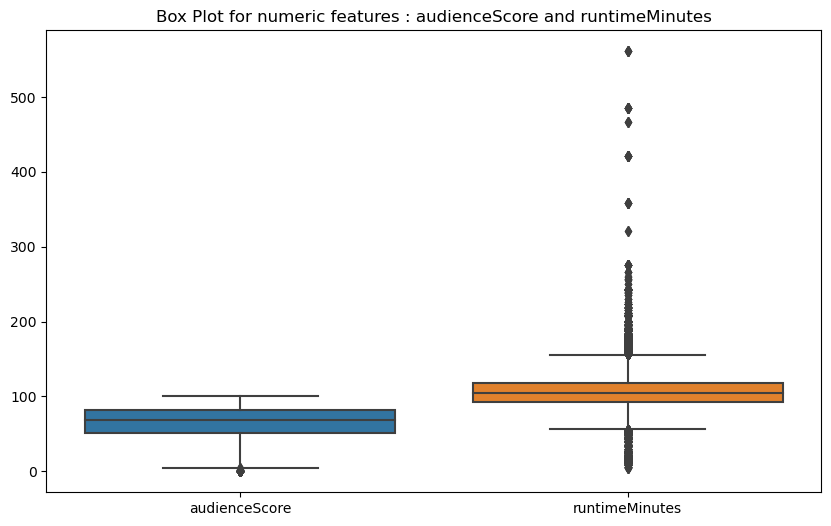

In [27]:
# set the figure size
plt.figure(figsize=(10, 6))

# FOR TRAINING DATA
# using boxplot from seaborn library 
# shows the numerical features with the outlier values present i.e. distribution of data
sns.boxplot(data=X_train)

plt.title("Box Plot for numeric features : audienceScore and runtimeMinutes")
plt.show()

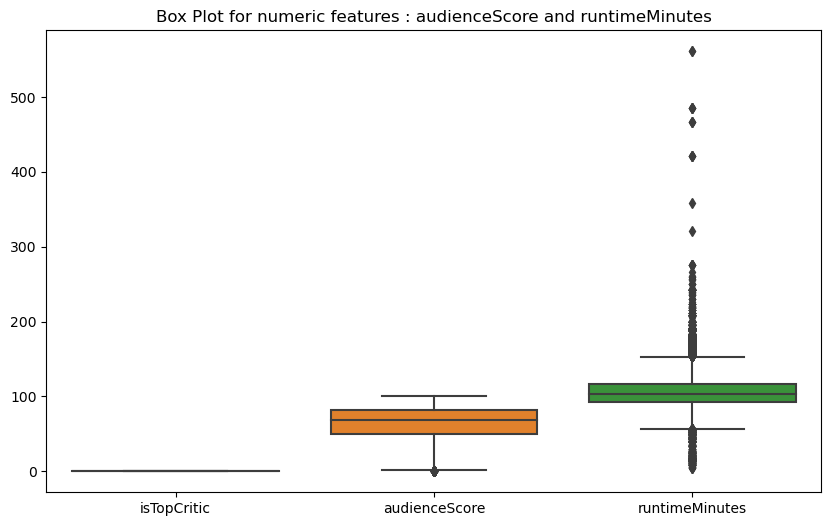

In [28]:
# set the figure size
plt.figure(figsize=(10, 6))

#FOR TEST DATA
# using boxplot from seaborn library 
# shows the numerical features with the outlier values present i.e. distribution of data
sns.boxplot(data=movie_test)

plt.title("Box Plot for numeric features : audienceScore and runtimeMinutes")
plt.show()

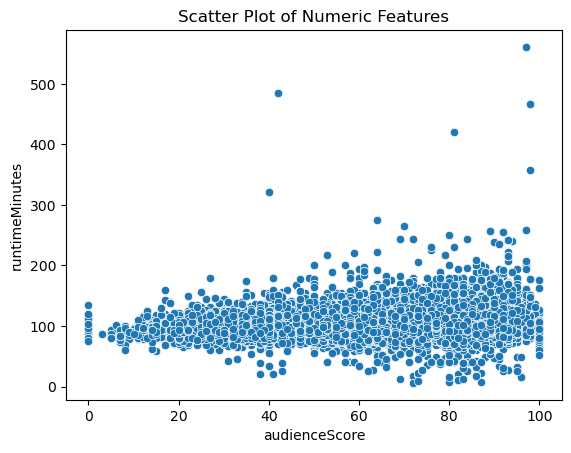

In [29]:
# FOR TRAINING DATA
# use scatterplot to visualize distribution of data between the two numerical features
sns.scatterplot(data=X_train, x='audienceScore', y='runtimeMinutes',markers=True)
plt.xlabel('audienceScore')
plt.ylabel('runtimeMinutes')
plt.title('Scatter Plot of Numeric Features')
plt.show()

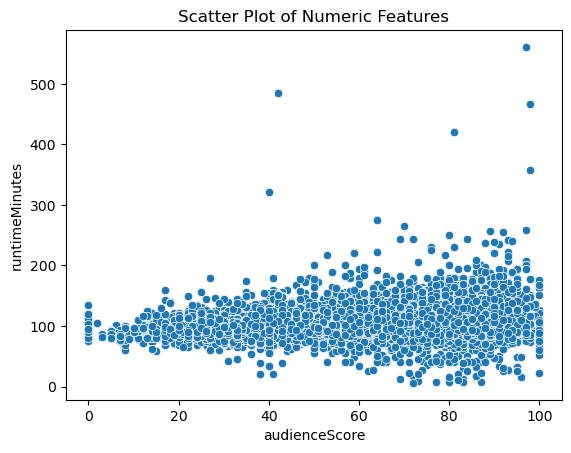

In [30]:
# FOR TEST DATA
# use scatterplot to visualize distribution of data between the two numerical features
sns.scatterplot(data=movie_test, x='audienceScore', y='runtimeMinutes',markers=True)
plt.xlabel('audienceScore')
plt.ylabel('runtimeMinutes')
plt.title('Scatter Plot of Numeric Features')
plt.show()

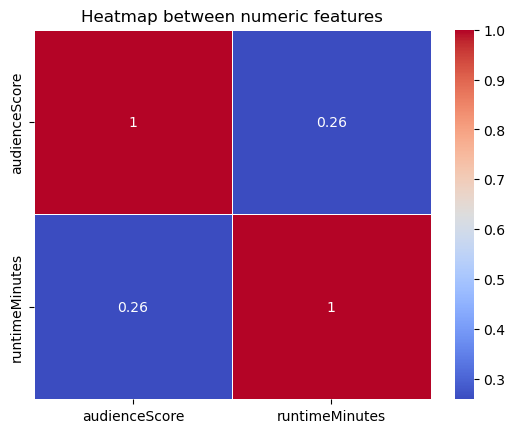

In [31]:
# TRAINING DATA
# defining the numerical features 
temp = X_train[['audienceScore','runtimeMinutes']]

#heatmap to explain correlation between numerical features
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm',linewidths=0.5)

plt.title('Heatmap between numeric features')
plt.show()

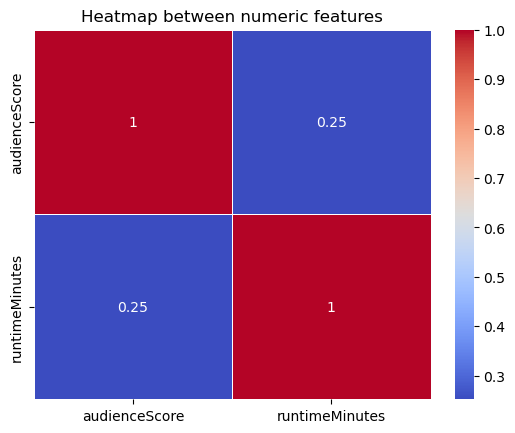

In [32]:
# TEST DATA
# defining the numerical features 
temp = movie_test[['audienceScore','runtimeMinutes']]

#heatmap to explain correlation between numerical features
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm',linewidths=0.5)

plt.title('Heatmap between numeric features')
plt.show()

# DATA PREPROCESSING

In [33]:
# defining the different features to apply preprocessing on

num_feature = ['audienceScore','runtimeMinutes']     # features containing numerical values
cat_feature = ['genre']                              # features containing categorical values
text_feature = 'reviewText'                          # features containing text values

**DEFINE PIPELINES**

In [34]:
# creating pipelines for each kind of features
# to apply data transformation
# Pipeline for numerical features
# first apply SimpleImputer which imputes or replaces the missing values of the numrical columns with
# a new value which contains 'mean' of the feature

#num_trans_1 pipeline containing standard scaler function
num_trans_1 = Pipeline(steps=[
    ('si', SimpleImputer(missing_values = np.nan,strategy='median')),
    ('scaler', StandardScaler())
])

#num_trans_2 pipeline containing min max scaler function
num_trans_2 = Pipeline(steps=[
    ('si', SimpleImputer(missing_values = np.nan,strategy='median')),
    ('scaler', MinMaxScaler())
])


# Pipeline for categorical features
# first apply SimpleImputer which imputes or replaces the missing values of categorical features with
# the most frequent value of the feature
cat_trans = Pipeline(steps=[
    ('si', SimpleImputer(missing_values = np.nan,strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [35]:
# use ColumnnTransformer to summarize the pipelines and the features to apply on 
# it contains the list of all transformers
# a transformer is a pipeline which contain transformations along with features to apply that pipeline on
# AND A VARIABLE NAME FOR THAT TRANSFORMER
transformer_1 = ColumnTransformer(
    transformers=[
        ('num', num_trans_1, num_feature),
        ('cat', cat_trans, cat_feature),
        ('text', TfidfVectorizer(), text_feature)
    ])

transformer_2 = ColumnTransformer(
    transformers=[
        ('num', num_trans_2, num_feature),
        ('cat', cat_trans, cat_feature),
        ('text', TfidfVectorizer(), text_feature)
    ])

In [36]:
#transformer 1 for those modls which require standard scaling
# using fit transform to ompute parameters required for a specific transformation
#and transform to apply the computed parameters from the fit to training data
x_transformed_1 = transformer_1.fit_transform(X_train)

In [37]:
#transformer 1 for those modls which require standard scaling
# using fit transform to ompute parameters required for a specific transformation
#and transform to apply the computed parameters from the fit to training data
x_transformed_2 = transformer_2.fit_transform(X_train)

In [38]:
#transformer 1 for satndard scaled validation data
# apply transform on validation data which uses the parameters used in fit
X_val_1 = transformer_1.transform(X_val)

In [39]:
#transformer 1 for satndard scaled validation data
# apply transform on validation data which uses the parameters used in fit
X_val_2 = transformer_2.transform(X_val)

In [40]:
X_test = transformer_1.transform(movie_test)

# APPLYING MODELS ON DATASET

**LOGISTIC REGRESSION MODEL**

In [41]:
# initilise logistic regression model with random state = 42
lr = LogisticRegression()

In [42]:
# defining param grid for the logistic regression model which can be used to fit the trainind data
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],            
}

In [43]:
# initialize GridSearchCV with LOGISTIC REGRESSION estimator and its defined parameters
gridSearch = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1)

In [44]:
# fitting the preprocessed training data
gridSearch.fit(x_transformed_1, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']})

In [45]:
# checking for the best hyperparameters for prediction
best_params = gridSearch.best_params_

In [46]:
# initialize new logistic regression model with the best hyperparameters chosen 
new_lr = LogisticRegression(**best_params, random_state=42)

In [47]:
# fitting the chosen hyperparameters on training data
new_lr.fit(x_transformed_1, y_train)

LogisticRegression(C=10, random_state=42)

In [48]:
# predicting the new model on validation data
y_pred = new_lr.predict(X_val_1)

In [49]:
print("Accuracy score of LOGISTIC REGRESSION model : ",accuracy_score(y_val, y_pred))

Accuracy score of LOGISTIC REGRESSION model :  0.8110838043745392


In [50]:
print("f1 score of LOGISTIC REGRESSION model : ",f1_score(y_val, y_pred, pos_label='POSITIVE'))

f1 score of LOGISTIC REGRESSION model :  0.8634563120592571


In [51]:
print("Classifcation report of LOGISTIC REGRESSION model : ")
print(classification_report(y_val, y_pred))

Classifcation report of LOGISTIC REGRESSION model : 
              precision    recall  f1-score   support

    NEGATIVE       0.75      0.65      0.69     13430
    POSITIVE       0.84      0.89      0.86     27260

    accuracy                           0.81     40690
   macro avg       0.79      0.77      0.78     40690
weighted avg       0.81      0.81      0.81     40690



**LINEAR SVC MODEL**

In [52]:
# Create a LinearSVC classifier
svc = LinearSVC()

In [53]:
# defining param grid for the logistic regression model which can be used to fit the training data
param_grid = {
    'C': [0.01, 0.1, 1, 10],        
    'max_iter': [100, 500],        
    'fit_intercept': [True, False]
}

In [54]:
# initialize GridSearchCV with LINEAR SVC estimator and its defined parameters
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)

In [55]:
# fitting the preprocessed training data
grid_search.fit(x_transformed_1, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 500]})

In [56]:
# checking for the best hyperparameters for prediction
best_params = grid_search.best_params_

In [57]:
# initialize new logistic regression model with the best hyperparameters chosen 
best_svc = LinearSVC(**best_params)

In [58]:
# fitting the chosen hyperparameters on training data
best_svc.fit(x_transformed_1, y_train)

LinearSVC(C=0.1, fit_intercept=False, max_iter=100)

In [59]:
# Make predictions on the test set
y_pred = best_svc.predict(X_val_1)

In [60]:
print("Accuracy score of LINEAR SVC model : ",accuracy_score(y_val, y_pred))

Accuracy score of LINEAR SVC model :  0.8132219218481199


In [61]:
print("f1 score of LINEAR SVC model : ",f1_score(y_val, y_pred, pos_label='POSITIVE'))

f1 score of LINEAR SVC model :  0.8664886515353805


In [62]:
print("Classifcation report of LINEAR SVC model : ")
print(classification_report(y_val, y_pred))

Classifcation report of LINEAR SVC model : 
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.63      0.69     13430
    POSITIVE       0.83      0.90      0.87     27260

    accuracy                           0.81     40690
   macro avg       0.80      0.77      0.78     40690
weighted avg       0.81      0.81      0.81     40690



**DECISION TREE MODEL**

In [63]:
# Create a DECISION TREE classifier
dt_model = DecisionTreeClassifier()

In [64]:
# defining param grid for the decision tree model which can be used to fit the training data
param_grid = {
    'max_depth': [3,5],
    'min_samples_split' : [2,3],
    'min_samples_leaf' : [1]
}

In [65]:
# initialize GridSearchCV with DECISION TREE estimator and its defined parameters
grid_search = GridSearchCV(dt_model, param_grid, cv=5)

In [66]:
# fitting the preprocessed training data
grid_search.fit(x_transformed_1, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3]})

In [67]:
# checking for the best hyperparameters for prediction
best_params = grid_search.best_params_

In [68]:
# initialize new decision tree model with the best hyperparameters chosen 
best_dt = DecisionTreeClassifier(**best_params)

In [69]:
# fitting the chosen hyperparameters on training data
best_dt.fit(x_transformed_1, y_train)

DecisionTreeClassifier(max_depth=5)

In [70]:
# Make predictions on the test set
y_pred = best_dt.predict(X_val_1)

In [71]:
print("Accuracy score of DECISION TREE model : ",accuracy_score(y_val, y_pred))

Accuracy score of DECISION TREE model :  0.7005898255099533


In [72]:
print("f1 score of DECISION TREE model : ",f1_score(y_val, y_pred, pos_label = 'POSITIVE'))

f1 score of DECISION TREE model :  0.7987112763320942


In [73]:
print("Classifcation report of DECISION TREE model : ")
print(classification_report(y_val, y_pred))

Classifcation report of DECISION TREE model : 
              precision    recall  f1-score   support

    NEGATIVE       0.58      0.32      0.42     13430
    POSITIVE       0.73      0.89      0.80     27260

    accuracy                           0.70     40690
   macro avg       0.66      0.60      0.61     40690
weighted avg       0.68      0.70      0.67     40690



**MULTINOMIAL NAIVE BAYES MODEL**

In [74]:
# Create a MULTINOMIAL NAIVE BAYES classifier
nb = MultinomialNB()

In [75]:
# defining param grid for the naive bayes model which can be used to fit the training data
from sklearn.naive_bayes import MultinomialNB
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],       
    'fit_prior': [True, False]
}

In [76]:
# initialize GridSearchCV with MULTINOMIAL NAIVE BAYES estimator and its defined parameters
grid_search = GridSearchCV(nb, param_grid, cv=5)

In [77]:
# fitting the preprocessed training data
grid_search.fit(x_transformed_2, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'fit_prior': [True, False]})

In [78]:
# checking for the best hyperparameters for prediction
best_params = grid_search.best_params_

In [79]:
# initialize new naive bayes model with the best hyperparameters chosen 
best_nb = MultinomialNB(**best_params)

In [80]:
# fitting the chosen hyperparameters on training data
best_nb.fit(x_transformed_2, y_train)

MultinomialNB(alpha=1, fit_prior=False)

In [81]:
# Make predictions on the test set
y_pred = best_nb.predict(X_val_2)

In [82]:
print("Accuracy score of MULTINOMIAL NAIVE BAYES model : ",accuracy_score(y_val, y_pred))

Accuracy score of MULTINOMIAL NAIVE BAYES model :  0.7811010076185795


In [83]:
print("f1 score of MULTINOMIAL NAIVE BAYES model : ",f1_score(y_val, y_pred, pos_label='POSITIVE'))

f1 score of MULTINOMIAL NAIVE BAYES model :  0.8385915952376638


In [84]:
print("Classifcation report of MULTINOMAIL NAIVE BAYES model : ")
print(classification_report(y_val, y_pred))

Classifcation report of MULTINOMAIL NAIVE BAYES model : 
              precision    recall  f1-score   support

    NEGATIVE       0.68      0.64      0.66     13430
    POSITIVE       0.83      0.85      0.84     27260

    accuracy                           0.78     40690
   macro avg       0.75      0.75      0.75     40690
weighted avg       0.78      0.78      0.78     40690



# LINEAR SVC is giving the best accuracy score for seen data. Predicting the unseen data on that model only

In [85]:
# predicting the test data on the best svc model calculated
y_pred_test = best_svc.predict(X_test)

In [86]:
# creating new dataframe
pred_df = pd.DataFrame(y_pred_test)

In [87]:
# dataframe contains only a single column as a feature
pred_df.columns = ["sentiment"]
pred_df.index.name = "id"

# SUBMISSION FILE
pred_df.to_csv("submission.csv")